In [1]:
from google.colab import drive
import pandas as pd
import os

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [64]:
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")
train_df = train_df.dropna(subset=['Burn Rate'])


In [65]:
cols_to_impute = ['Mental Fatigue Score', 'Resource Allocation']
imputer = SimpleImputer(strategy='mean')
train_df[cols_to_impute] = imputer.fit_transform(train_df[cols_to_impute])
test_df[cols_to_impute] = imputer.transform(test_df[cols_to_impute])


 Random Forest RMSE: 0.06267171091631754


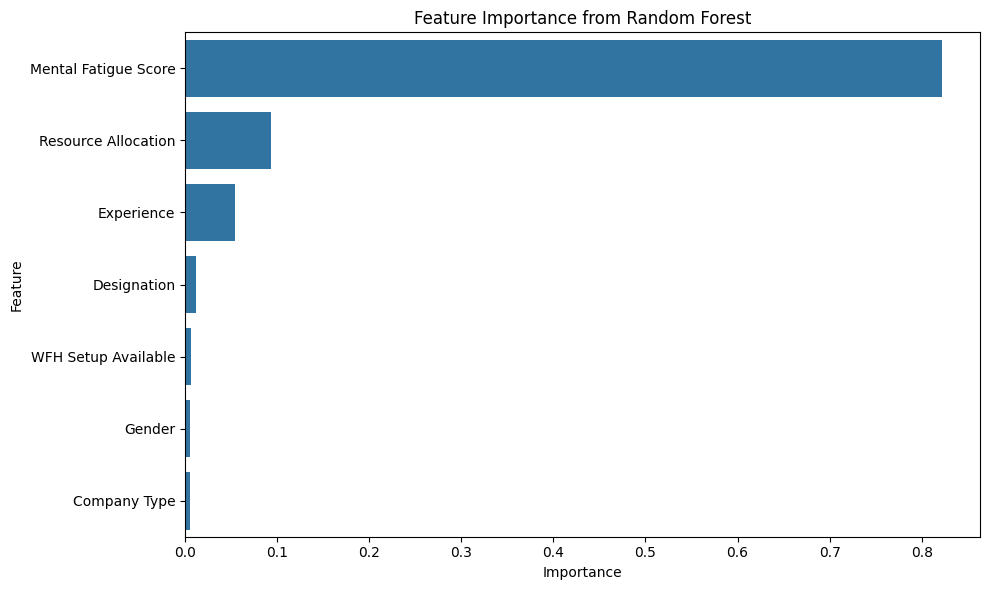

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


541/541 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0276 - mae: 0.0992 - val_loss: 0.0052 - val_mae: 0.0556
Epoch 2/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0050 - mae: 0.0541 - val_loss: 0.0047 - val_mae: 0.0530
Epoch 3/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0049 - mae: 0.0540 - val_loss: 0.0044 - val_mae: 0.0519
Epoch 4/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0046 - mae: 0.0527 - val_loss: 0.0046 - val_mae: 0.0525
Epoch 5/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0046 - mae: 0.0522 - val_loss: 0.0049 - val_mae: 0.0555
Epoch 6/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0044 - mae: 0.0516 - val_loss: 0.0041 - val_mae: 0.0501
Epoch 7/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0044 - mae: 0.0514 - val_loss: 0.0042 - val_mae: 0.0508
Epoch 8/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0043 - mae: 0.0514 - val_loss: 0.0046 - val_mae: 0.0533
Epoch 9/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0044 

In [66]:
train_df['Date of Joining'] = pd.to_datetime(train_df['Date of Joining'])
test_df['Date of Joining'] = pd.to_datetime(test_df['Date of Joining'])
train_df['Experience'] = (pd.to_datetime("2025-01-01") - train_df['Date of Joining']).dt.days / 365
test_df['Experience'] = (pd.to_datetime("2025-01-01") - test_df['Date of Joining']).dt.days / 365

cat_cols = ['Gender', 'Company Type', 'WFH Setup Available']
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    encoders[col] = le

test_ids = test_df['Employee ID']
train_df.drop(columns=['Employee ID', 'Date of Joining'], inplace=True)
test_df.drop(columns=['Employee ID', 'Date of Joining'], inplace=True)


X = train_df.drop(columns=['Burn Rate'])
y = train_df['Burn Rate']
X_test = test_df.copy()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)


rf_model = RandomForestRegressor(n_estimators=150, random_state=42)
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)


y_pred_rf = rf_model.predict(X_val_rf)
print(" Random Forest RMSE:", np.sqrt(mean_squared_error(y_val_rf, y_pred_rf)))

importances = rf_model.feature_importances_
feat_names = X.columns
imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=imp_df, x='Importance', y='Feature')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()


model = Sequential([
    Dense(128, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


history = model.fit(X_scaled, y, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


predictions = model.predict(X_test_scaled)

submission = pd.DataFrame({
    "Employee ID": test_ids,
    "Predicted Burn Rate": predictions.flatten()
})
submission.to_csv("submission.csv", index=False)
print(" Predictions saved to 'submission.csv'")


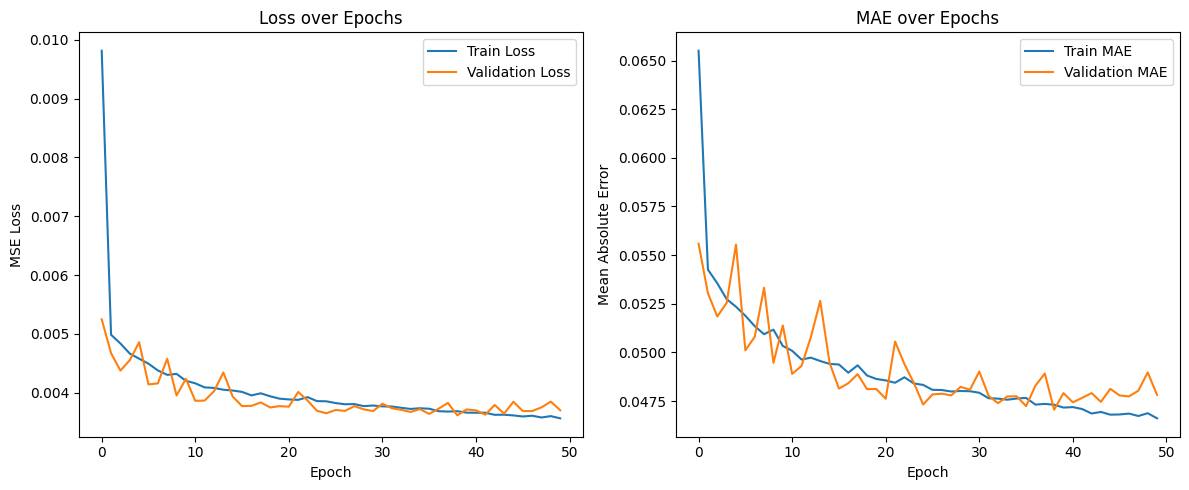

In [67]:



plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.tight_layout()
plt.show()


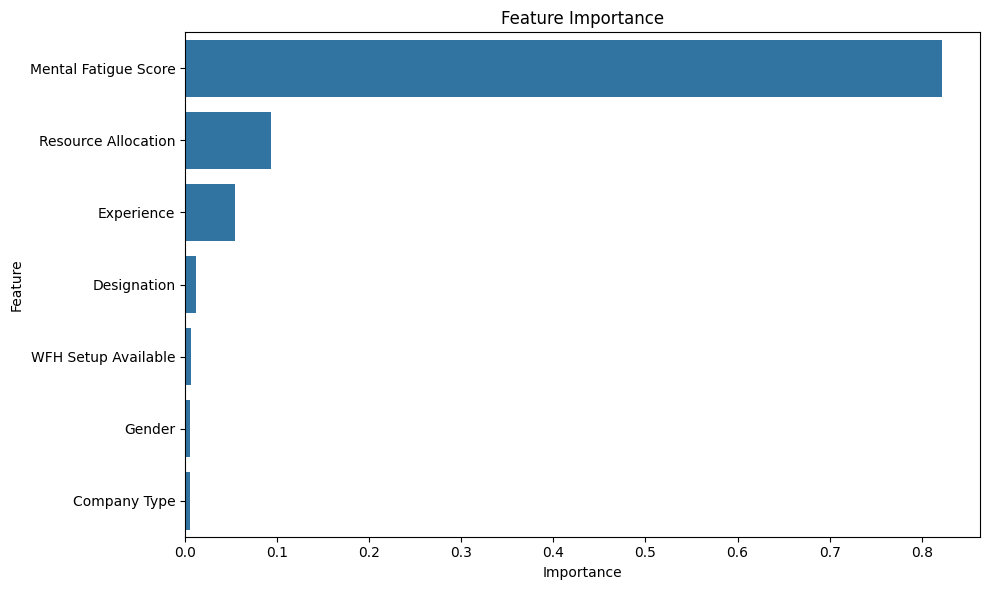

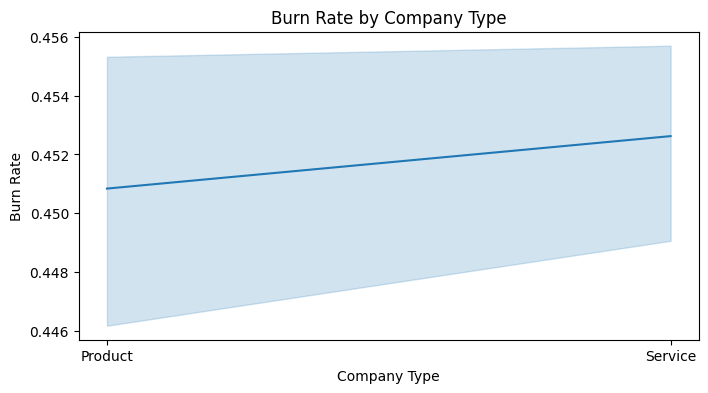

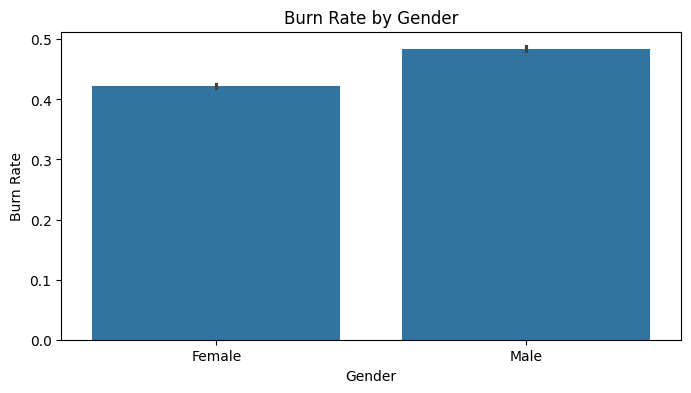

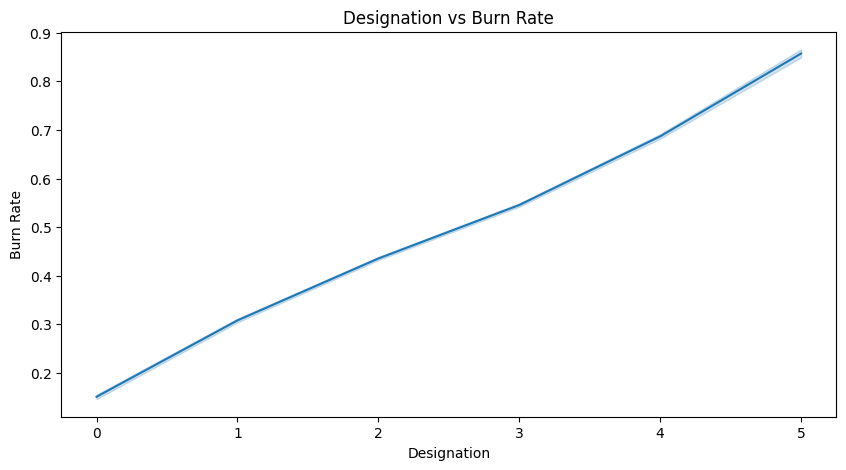

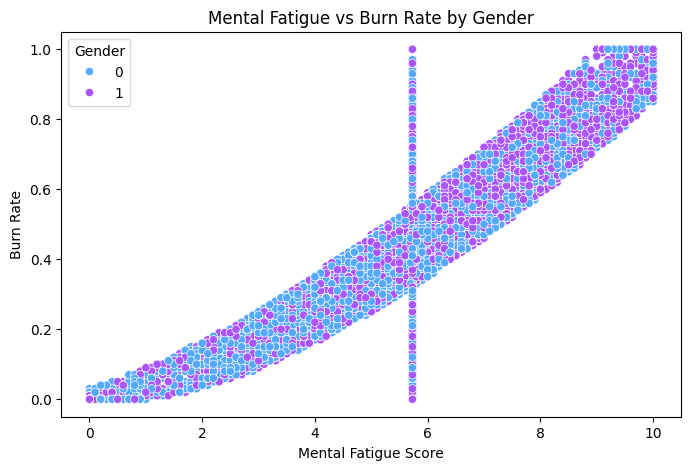

In [68]:
plt.figure(figsize=(10, 6))
sns.barplot(data=imp_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(x='Company Type', y='Burn Rate', data=train_df)
plt.title("Burn Rate by Company Type")
plt.xticks(ticks=[0, 1], labels=encoders['Company Type'].classes_)
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x='Gender', y='Burn Rate', data=train_df)
plt.title("Burn Rate by Gender")
plt.xticks(ticks=[0, 1], labels=encoders['Gender'].classes_)
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=train_df, x='Designation', y='Burn Rate')
plt.title("Designation vs Burn Rate")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=train_df, x='Mental Fatigue Score', y='Burn Rate', hue='Gender', palette='cool')
plt.title("Mental Fatigue vs Burn Rate by Gender")
plt.show()

In [69]:
test_df['Experience']

,Experience
0,16.071233
1,16.394521
2,16.145205
3,16.912329
4,16.471233
...,...
12245,16.260274
12246,16.767123
12247,16.898630
12248,16.915068


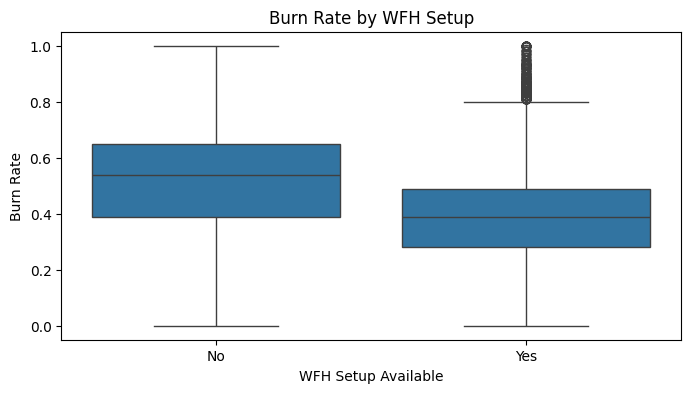

<ipython-input-70-08b754d9fb25>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=wfh_burn, x='WFH Setup Available', y='Burn Rate', palette='Set2')


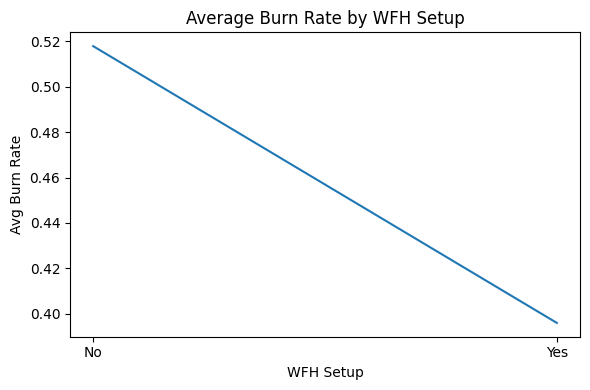

In [70]:

plt.figure(figsize=(8, 4))
sns.boxplot(x='WFH Setup Available', y='Burn Rate', data=train_df)
plt.title("Burn Rate by WFH Setup")
plt.xticks(ticks=[0, 1], labels=encoders['WFH Setup Available'].classes_)
plt.show()

wfh_burn = train_df.groupby('WFH Setup Available')['Burn Rate'].mean().reset_index()
wfh_burn['WFH Setup Available'] = wfh_burn['WFH Setup Available'].map({i: encoders['WFH Setup Available'].inverse_transform([i])[0] for i in wfh_burn['WFH Setup Available']})

plt.figure(figsize=(6, 4))
sns.lineplot(data=wfh_burn, x='WFH Setup Available', y='Burn Rate', palette='Set2')
plt.title("Average Burn Rate by WFH Setup")
plt.ylabel("Avg Burn Rate")
plt.xlabel("WFH Setup")
plt.tight_layout()
plt.show()


In [71]:
df_pred = pd.read_csv("/content/submission.csv")

def classify_burnout(rate):
    if rate <= 0.4:
        return 'Low'
    elif rate <= 0.7:
        return 'Medium'
    else:
        return 'High'

df_pred['Burnout Level'] = df_pred['Predicted Burn Rate'].apply(classify_burnout)


In [32]:
test_raw = pd.read_csv('/content/drive/MyDrive/test.csv')
test_raw['Burnout Level'] = df_pred['Burnout Level']


In [72]:
def burnout_percentages(df, column):
    counts = df.groupby([column, 'Burnout Level']).size().unstack().fillna(0)
    percents = counts.div(counts.sum(axis=1), axis=0) * 100
    return percents

# Run for key columns
cols = ['Gender', 'Company Type', 'Designation', 'WFH Setup Available']
burnout_stats = {col: burnout_percentages(test_raw, col) for col in cols}


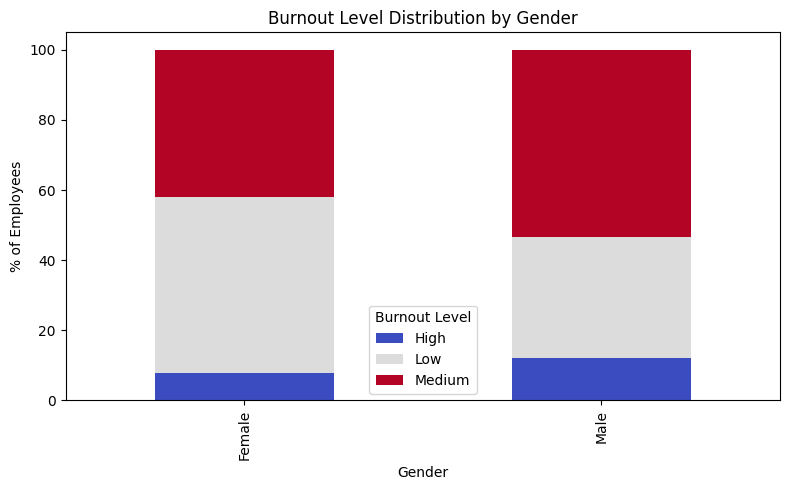

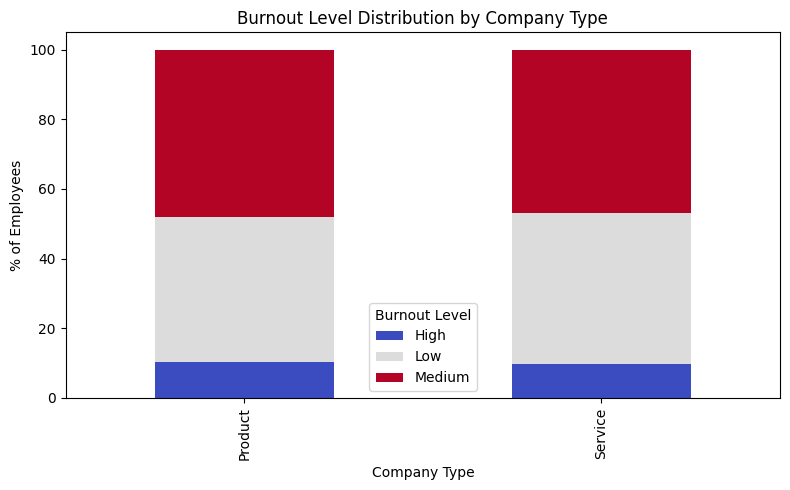

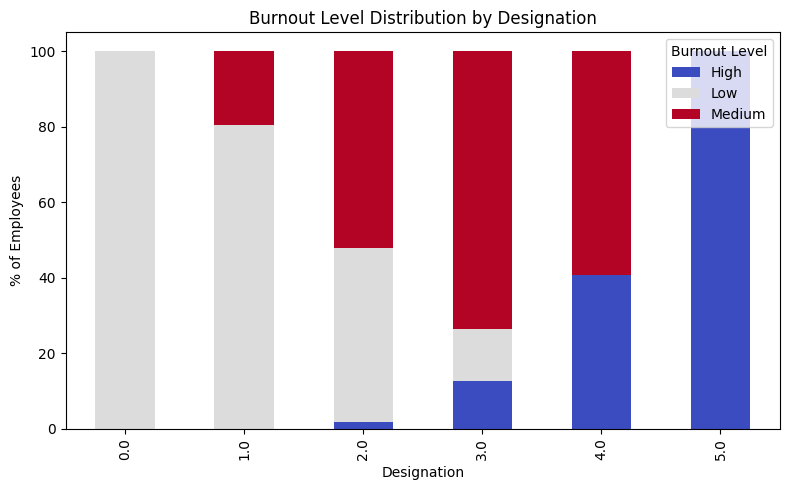

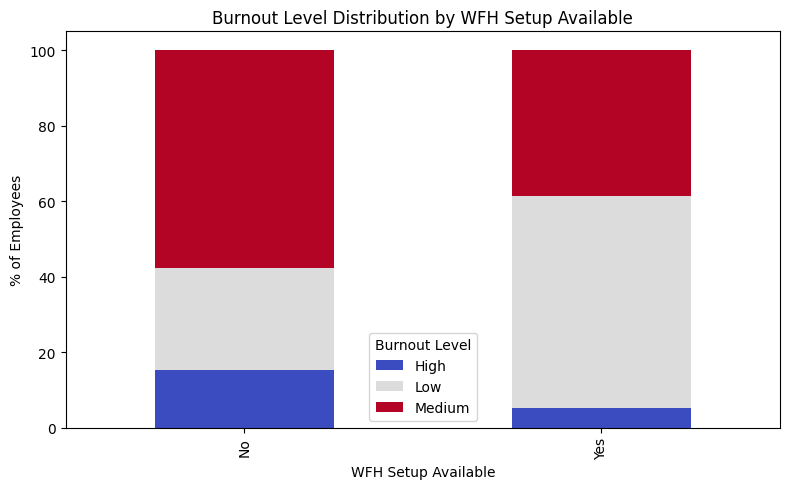

In [73]:
for col, df in burnout_stats.items():
    df.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8, 5))
    plt.title(f'Burnout Level Distribution by {col}')
    plt.ylabel('% of Employees')
    plt.xlabel(col)
    plt.legend(title='Burnout Level')
    plt.tight_layout()
    plt.show()


In [79]:
df = pd.read_csv("/content/drive/MyDrive/test.csv")
df_pred = pd.read_csv("/content/submission.csv")
df['Predicted Burn Rate'] = df_pred['Predicted Burn Rate']

# Classify burnout levels
def classify_burnout(rate):
    if rate <= 0.4:
        return 'Low'
    elif rate <= 0.7:
        return 'Medium'
    else:
        return 'High'

df['Burnout Level'] = df['Predicted Burn Rate'].apply(classify_burnout)


In [80]:

columns = ['Gender', 'Company Type', 'Designation', 'WFH Setup Available']
heatmap_data = []

for col in columns:
    temp = df.groupby([col, 'Burnout Level']).size().unstack(fill_value=0)
    temp_percent = temp.div(temp.sum(axis=1), axis=0) * 100
    temp_percent.index = [f"{col}: {val}" for val in temp_percent.index]
    heatmap_data.append(temp_percent)

heatmap_df = pd.concat(heatmap_data)


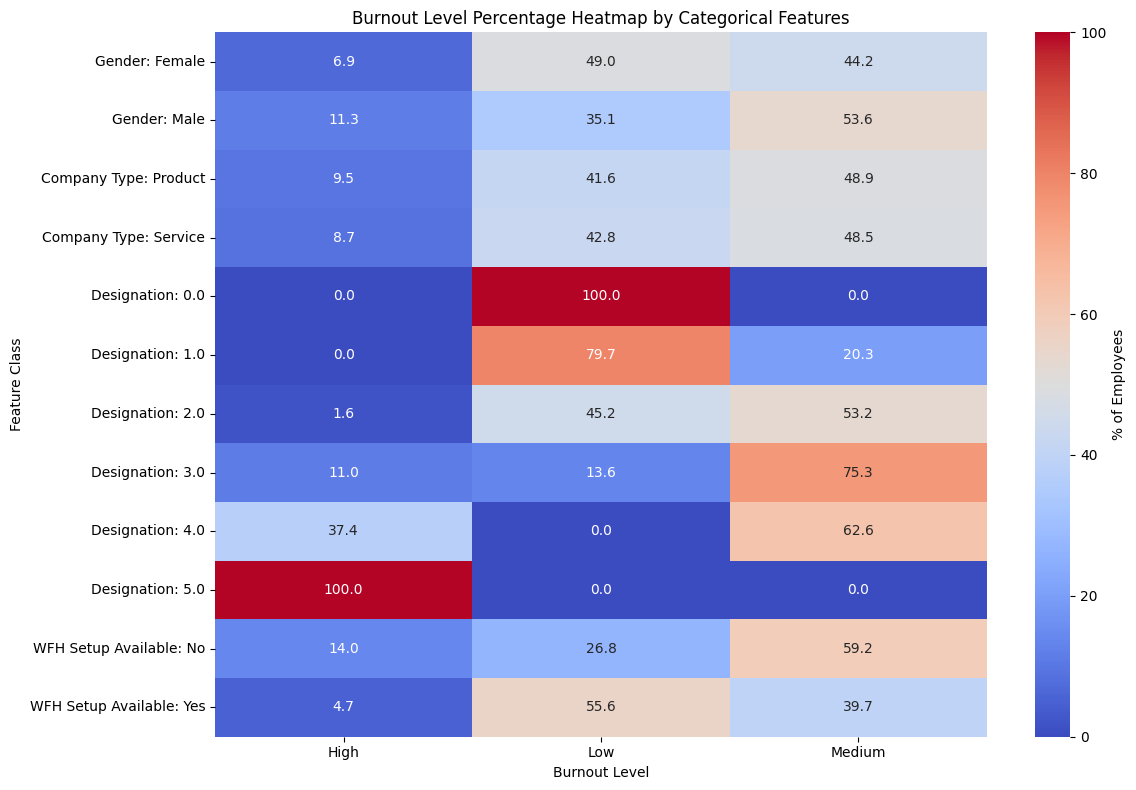

In [81]:
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': '% of Employees'})
plt.title("Burnout Level Percentage Heatmap by Categorical Features")
plt.ylabel("Feature Class")
plt.xlabel("Burnout Level")
plt.tight_layout()
plt.show()
